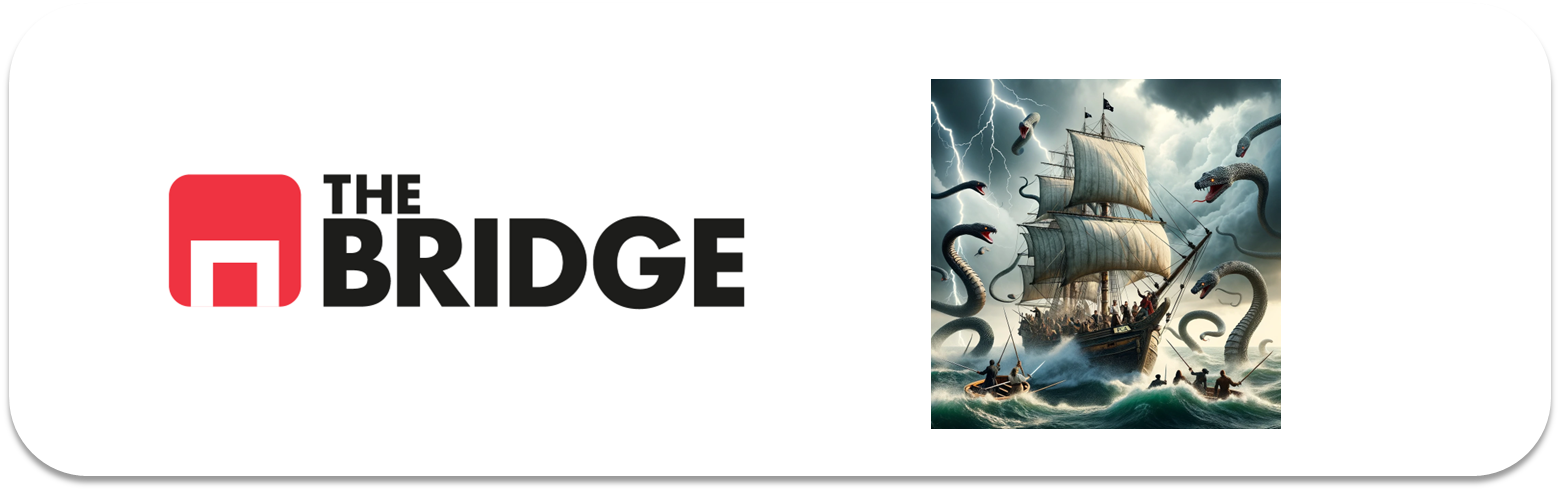

## **Seleccion Features**

### Descripción General y Objetivo

El objetivo de la práctica es que juegues con las diferentes técncias de selección de features sobre un problema de clasificación. Para ello, tendrás que cargar el dataset de credit scoring que tienes en la carpeta "data" y que ya hemos trabajado anteriormente. A partir de ahí tendrás que probar diferentes técnicas de selección de features y compararlas todas entre sí y escoger finalmente el conjunto más sencillo con más potencia. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from lightgbm import LGBMClassifier
from scipy.stats import mannwhitneyu
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, SelectFromModel, RFE, SequentialFeatureSelector
from sklearn.metrics import mutual_info_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from xgboost import XGBClassifier


### Detalles e Instrucciones

El objetivo es que construyas un modelo final de clasificació sobre la variable "SeriousDlqin2yrs" del dataset que encontrarás en "data".  

Sigue los pasos del proceso de ML que hemos aprendido para problemas supervisados con el dataset que encontrarás en "data" pero con las siguiente salvedades:

1. Deshazte de las filas con nulos, para este ejercicio no nos importan. Convierte las features NumberOf... que creas conveniente a categóricas con 2 o 3 niveles a lo sumo.

2. A la hora de hacer el miniEda aplica los siguientes análisis y selección de features: 
    1. Análisis visual combinado con filtrado por valores de correlación y umbral de covarianza.
    2. Selección de features numéricas mediante SelectKBest y ANOVA, selecció de features categóricas mediante Mutual Information 
    3. Selección de las mejores features a través de un modelo intermedio (usando SelectFromModel)
    4. Selección de las mejores features empleando RFE.
    5. Selección de las mejores features empleando SFS.
    6. Selección de las mejores features mediante un sistema de hard-voting aplicado a lo obtenido en los pasos 1 a 5 anteriores.

    Para cada paso anterior (salvo el 1) se pide obtener una lista de features de "primera división" con un número de variables no superior a 6 (pueden ser menos).

3. Escoge tres modelos y a la hora compararlos para escoger el mejor, entrenalos con validación cruzada empleando las seis listas obtenidas anteriormente. Es decir tendrás 18 (6*3) medidas (emplea la métrica que creas más conveniente y si no se te ocurre ninguna el recall medio).  Escoge el mejor modelo y la mejor selección de features.

4. Optimiza los hiperparámetros del mejor modelo. Evalúalo contra test.


*Pasos ML:*  

*1. Entender Problema -> Tener claro lo siguiente: tipo de aprendizaje, modelos posibles, target o no, métrica o sistema de evaluación (para no supervisados esto es muy importante). EN ESTA PRACTICA nos quedamos con modelo supervisado de clasificación con target en predecir la posible deuda de más de 90 días en los próximos dos años, y métrica el recall medio (por lo desbalancedo del target aunque todavía no lo hayamos visto :-))*   
  
*2. Cargar datos, primer vistazo*

In [2]:
df = pd.read_csv("./data/credit_npo.csv")
df

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
12532,0,0.197116,59,0,0.290216,5140.0,6,0,1,0,0.0
12533,0,0.036726,62,0,0.884985,5833.0,12,0,1,0,0.0
12534,0,0.120313,49,0,0.577676,6333.0,7,0,2,0,2.0
12535,0,0.252566,63,0,0.037640,14000.0,9,0,0,0,1.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

*Tal y como nos indican en el enunciado nos deshacemos de las filas con nulos. Esto es porque es un ejercicio académico, pero en la vida real ¿qué implicación tiene deshacerse de filas con nulos? Que en los datos futuros para predecir tendremos que tener todas las columnas informadas o reconstruirlo de alguna forma* 

In [4]:
df.dropna(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11816 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      11816 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  11816 non-null  float64
 2   age                                   11816 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  11816 non-null  int64  
 4   DebtRatio                             11816 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       11816 non-null  int64  
 7   NumberOfTimes90DaysLate               11816 non-null  int64  
 8   NumberRealEstateLoansOrLines          11816 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  11816 non-null  int64  
 10  NumberOfDependents                    11816 non-null  float64
dtypes: float64(4), int64

In [5]:
target = "SeriousDlqin2yrs"

3. Train y Test


In [6]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state= 42)

4. MiniEDA

*4.1 Análisis del target*

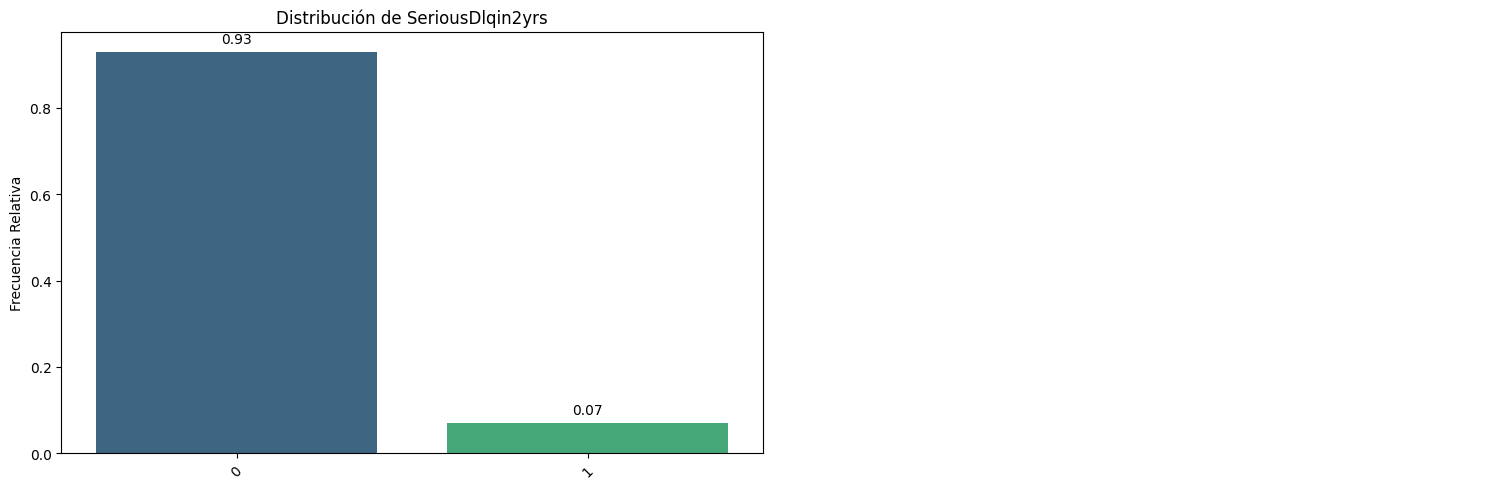

In [7]:
bt.pinta_distribucion_categoricas(train_set, [target], True, True)

*Ya conocíamos este dataset en el que hay un desequilibrio importante. Aunque vamos a emplear el recall medio ("balanced_accuracy") este tipo de desequilibrios en general piden unas metricas más de clase, es decir la precisión de la clase mayoritaria o el recall de la minoritaria o viceversa*

*4.2 Clasificación y transformación de las variables: Vamos a ver cuales son numéricas y cuáles categóricas y además como nos piden que transformemos las variables "NumberOf" en categóricas lo haremos también. Recuerda que si las clasificamos así es porque el tratamiento y análisis es diferente según sean de un tipo u otro.*

*Para ver si son categóricas o numéricas podemos utilizar nuestras funciones del toolbox o usar un describe y un hist:*

In [8]:
train_set.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000
mean,0.070144,0.335207,51.491536,0.343314,0.486047,6868.428058,8.794647,0.180279,1.064325,0.152772,0.863415
std,0.255403,0.362233,14.499298,2.930489,2.505031,12580.543336,5.139555,2.889984,1.148156,2.870119,1.158238
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.034869,41.000000,0.000000,0.146204,3466.000000,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.179211,51.000000,0.000000,0.297564,5441.000000,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.587533,62.000000,0.000000,0.477876,8300.000000,11.000000,0.000000,2.000000,0.000000,2.000000
max,1.000000,6.000000,101.000000,98.000000,96.000000,702500.000000,49.000000,98.000000,19.000000,98.000000,10.000000


(10, 2)


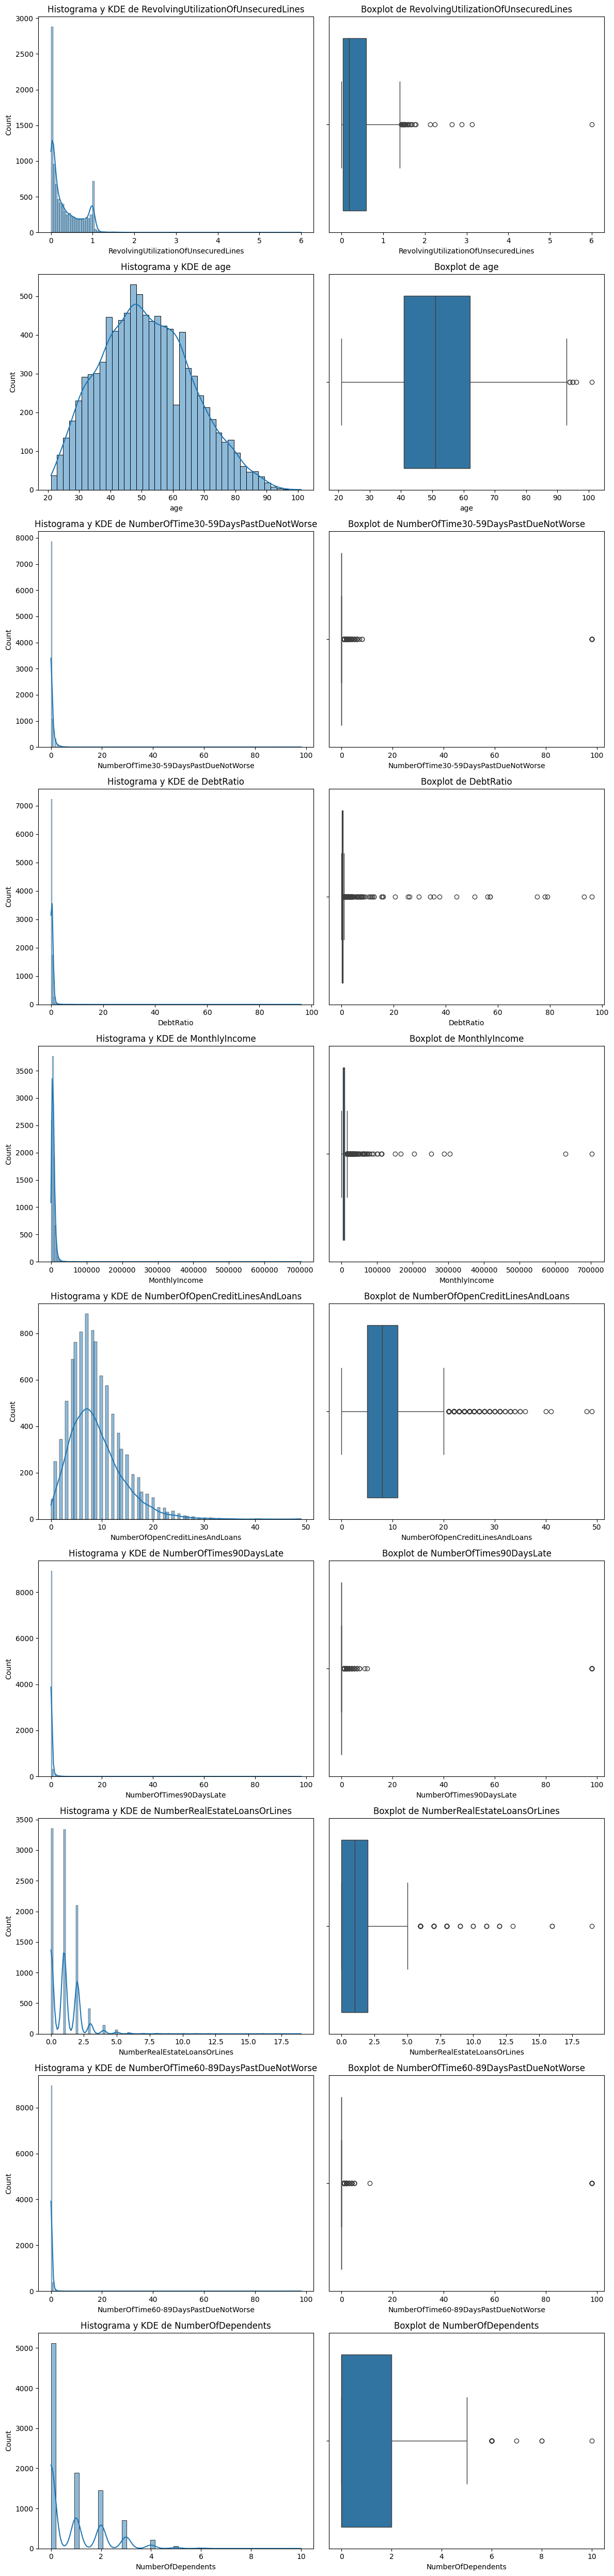

In [9]:
bt.plot_combined_graphs(train_set, [col for col in train_set.columns if col != target])

* *RevolvingUtilizationOfUnsecuredLines*: Númerica continua
* *age*: Numérica continua
* *NumberOfTime30-59DaysPastDueNotWorse*: El valor 98 lo distorsiona, si nos fijamos en sus quantiles (0) y en el combinado de histograma y caja, es claramente categorizable. Haremos un value_counts para decidir esa categorizacion.
* *DebtRatio*: La consideramos numéricas continuas, por rango y valores.
* *MonthlyIncome*: Numérica continua
* *NumberOfOpenCreditLinesAndLoans*: Numérica discreta pero por cantidad de valores la consideramos numérica continua.
* *NumberOfTimes90DaysLate*: Le ocurre lo mismo que a NumberOfTime30-50DaysPastDueNotWorse. Nos fijaremos en el value_counts para ver su categorización.
* *NumberRealEstateLoansOrLines*: Esta es una feature con outliers dispersos pero que parece concentrada en 5 valores, miraremos su value_counts y su bivariante con el target para tomar una decisión que probablemente será categorizarla. 
* *NumberOfTime60-89DaysPastDueNotWorse*: Como las otras dos variables del estilo (NumberOfTime30-59DaysPastDueNotWorse, NumberOfTimes90DaysLate), se concentra en 0 y tiene varios outliers y está sesgada por el valor 98. La categorizaremos después de ver su value_counts.
* *NumberOfDependents*: Numérica discreta que no tocaremos.

*Ya podemos crear la lista de numéricas (continuas y discretas que vamos a tratar como numéricas):*

In [10]:
features_num = ["RevolvingUtilizationOfUnsecuredLines","age","DebtRatio","MonthlyIncome",
                "NumberOfOpenCreditLinesAndLoans","NumberOfDependents"]

*Analizamos con un poco más de detalle "NumberRealEstateLoansOrLines" para decidir si categórica o numérica:*

In [11]:
train_set["NumberRealEstateLoansOrLines"].value_counts()

NumberRealEstateLoansOrLines
0     3356
1     3334
2     2095
3      413
4      137
5       67
6       19
8        8
7        8
11       3
12       3
9        3
10       2
16       2
13       1
19       1
Name: count, dtype: int64

*Existen bastantes valores entre 0 y 4 y ya menos en 5 y a patir de ahí casi no hay instancias (filas del dataframe) con 6 o más. Podríamos crear una categoria "mas de 6" o 7 que incluya todos los valores iguales o por encima de 6, por simplicidad la dejamos tal cual y la consideramos numérica discreta. ¿Pero entonces cuando te quedas una numérica discreta o la consideras categórica? Si tengo tiempo haría las dos consideraciones. ¿La diferencia? El hecho de que los valores 6 a 19 los convertiría en un único valor "7" y luego trataría ambas como ordinales (no haría otra codificación). Probaría las "dos" features por ver cual aporta más. Como no tenemos más tiempo, lo dejo en numérica discreta, en definitiva, no la toco*

In [12]:
features_num.append("NumberRealEstateLoansOrLines")

*Categoricemos NumberOfTime30-59DaysPastDueNotWorse, NumberOfTime60-89DaysPastDueNotWorse, NumberOfTimes90DaysLate:*

In [13]:
train_set["NumberOfTime30-59DaysPastDueNotWorse"].value_counts(True)

NumberOfTime30-59DaysPastDueNotWorse
0     0.831147
1     0.113521
2     0.033644
3     0.010897
4     0.005607
5     0.002116
6     0.001904
98    0.000846
8     0.000212
7     0.000106
Name: proportion, dtype: float64

*Una regla del dedo gordo, hacer "categorias" de cualquier valor discreto con 10% o más de instancias. En este caso aplicando esa regla tendríamos 0,1, y +de 1. Voy a hacer 3 y las voy a "codificar" ya como 0,1,2*

In [14]:
n_corto = "NumberOfTime30-59DaysPastDueNotWorse"
train_set[train_set[target] == 1][n_corto].value_counts(True)

NumberOfTime30-59DaysPastDueNotWorse
0     0.502262
1     0.251885
2     0.123680
3     0.051282
4     0.034691
5     0.015083
6     0.013575
98    0.007541
Name: proportion, dtype: float64

In [15]:
# Me simplifico la vida con el nombre
n_corto = "NumberOfTime30-59DaysPastDueNotWorse"
# Método 1, con pd.cut
labels = [0,1,2] # Cambio 
train_set["N30-59"] = pd.cut(train_set[n_corto], bins = [-1,0,1,10000], labels = labels, right= True).astype(int) # right a True para incluir los valores "a la derecha" en el bin (es decir -1,0 incluye a todos los valores >-1 y <= 0)
test_set["N30-59"] = pd.cut(test_set[n_corto], bins = [-1,0,1,10000], labels = labels, right= True).astype(int) 
train_set["N30-59"].value_counts(True)

N30-59
0    0.831147
1    0.113521
2    0.055332
Name: proportion, dtype: float64

Además podemos comprobar si esa codificación "refleja" la tendencia a "tener deuda":*

In [16]:
train_set[train_set[target] == 1]["N30-59"].value_counts(True)

N30-59
0    0.502262
1    0.251885
2    0.245852
Name: proportion, dtype: float64

*Viendo esto podríamos incluso haber dejado solo dos categorías (fijate que las frecuencias de "impagadores" son similares para 1 y para 2), pero nos vamos a quedar con las tres por no complicar más el notebook (sí, si tuvieramos más tiempo y espacio lo haríamos con dos categorizaciones también :-). Siguiente*

In [17]:
train_set["NumberOfTime60-89DaysPastDueNotWorse"].value_counts(True)

NumberOfTime60-89DaysPastDueNotWorse
0     0.947207
1     0.040521
2     0.008041
3     0.001481
4     0.001375
98    0.000846
5     0.000423
11    0.000106
Name: proportion, dtype: float64

*Aquí escogemos dos categorías 0 y 1 o más:*

In [18]:
train_set["N60-89"] = (train_set["NumberOfTime60-89DaysPastDueNotWorse"] > 0).astype(int)
test_set["N60-89"] = (test_set["NumberOfTime60-89DaysPastDueNotWorse"] > 0).astype(int)
train_set["N60-89"].value_counts(True)

N60-89
0    0.947207
1    0.052793
Name: proportion, dtype: float64

In [19]:
train_set[train_set[target] == 1]["N60-89"].value_counts(True)

N60-89
0    0.746606
1    0.253394
Name: proportion, dtype: float64

In [20]:
train_set[train_set[target] == 0]["N60-89"].value_counts(True)

N60-89
0    0.962339
1    0.037661
Name: proportion, dtype: float64

*Tiene buena pinta (luego lo analizamos con detalle)*

In [21]:
train_set["NumberOfTimes90DaysLate"].value_counts(True)

NumberOfTimes90DaysLate
0     0.943610
1     0.033115
2     0.012590
3     0.004655
4     0.002751
5     0.001481
98    0.000846
6     0.000529
7     0.000212
9     0.000106
10    0.000106
Name: proportion, dtype: float64

*Dos categorías 0 y uno o más:*

In [22]:
train_set["N90"] = (train_set["NumberOfTimes90DaysLate"] > 0).astype(int)
test_set["N90"] = (test_set["NumberOfTimes90DaysLate"] > 0).astype(int)
train_set["N90"].value_counts(True)

N90
0    0.94361
1    0.05639
Name: proportion, dtype: float64

In [23]:
train_set[train_set[target] == 1]["N90"].value_counts(True)

N90
0    0.642534
1    0.357466
Name: proportion, dtype: float64

In [24]:
train_set[train_set[target] == 0]["N90"].value_counts(True)

N90
0    0.966322
1    0.033678
Name: proportion, dtype: float64

*Igual que la anterior tiene buena pinta. Y ya tenemos nuestras categóricas:*

In [25]:
features_cat = ["N30-59","N60-89","N90"]


In [26]:

features_num

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfDependents',
 'NumberRealEstateLoansOrLines']

4.3 **Análisis visual con estadísticos matemáticos**

*Hagamos nuestros análisis bivariantes para hacer la selección de las variables "visualmente", como hemos venido haciendo hasta ahora. Empezamos con las categóricas*

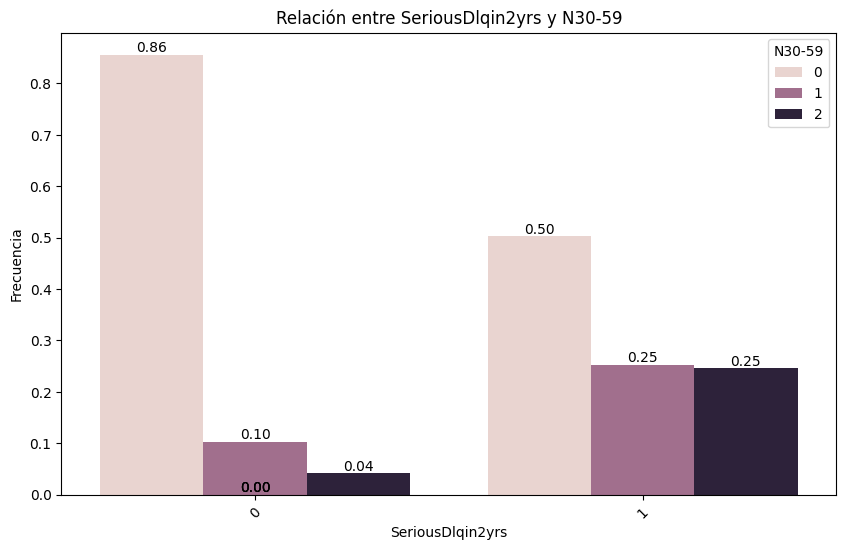

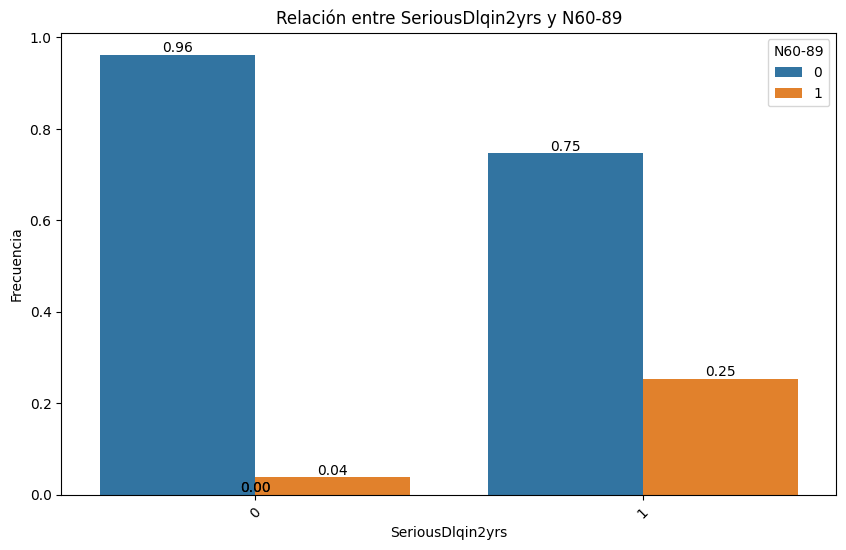

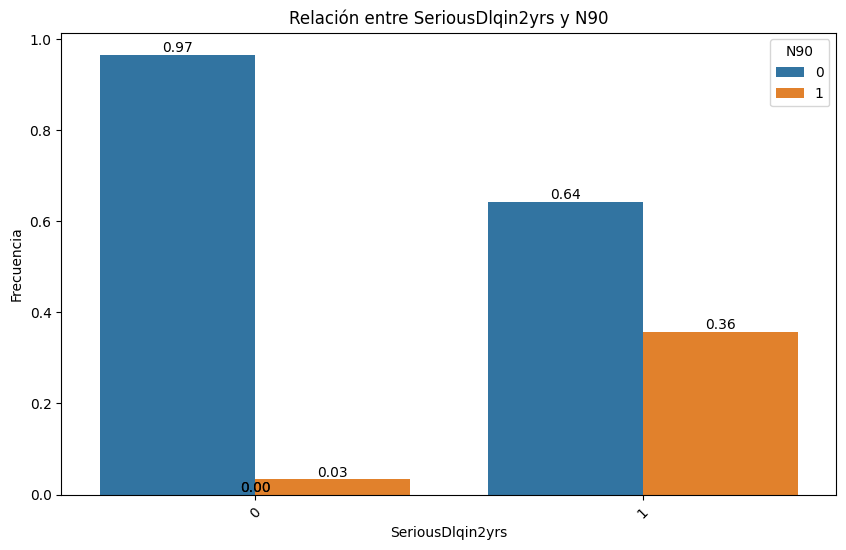

In [27]:
for col in features_cat:
    bt.plot_categorical_relationship_fin(train_set, target, col, True, True)

*Las tres tienen diferencias destacadas según el valor del target, son de "primera división"*

In [28]:
features_visual = features_cat.copy()

*Vamos con las numéricas*

In [29]:
#sns.pairplot(train_set[features_num + [target]], hue = target)

*Graficas demasiado pequeñas, usaremos nuestras tools*

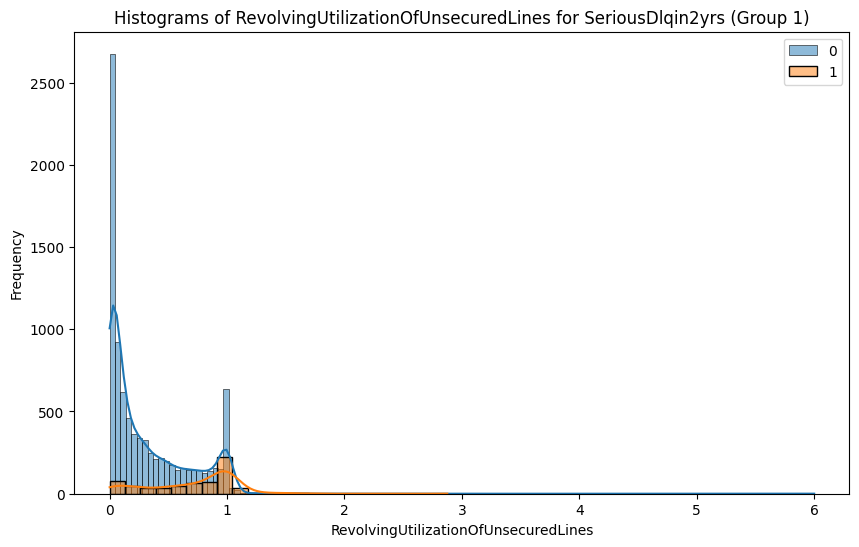

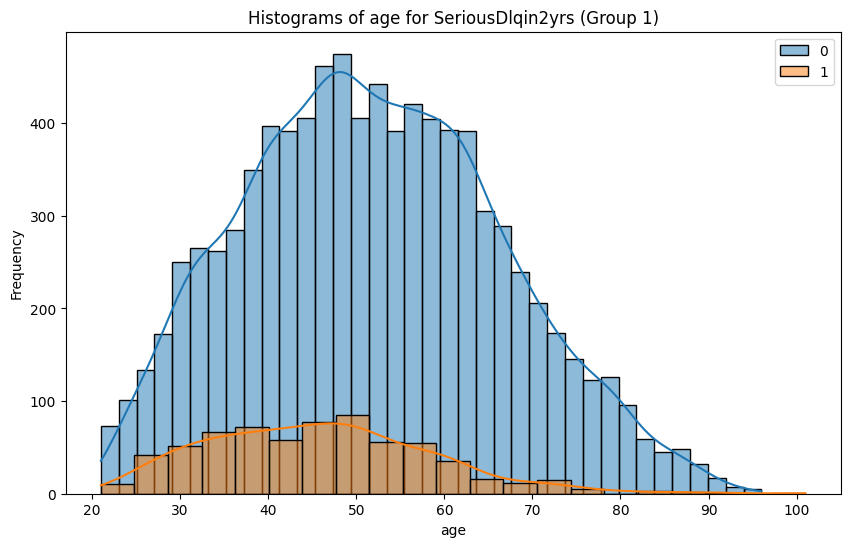

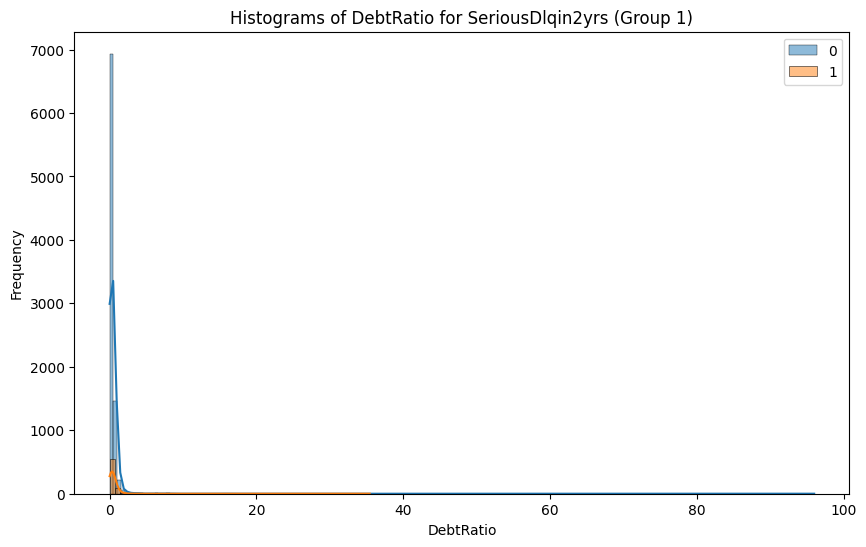

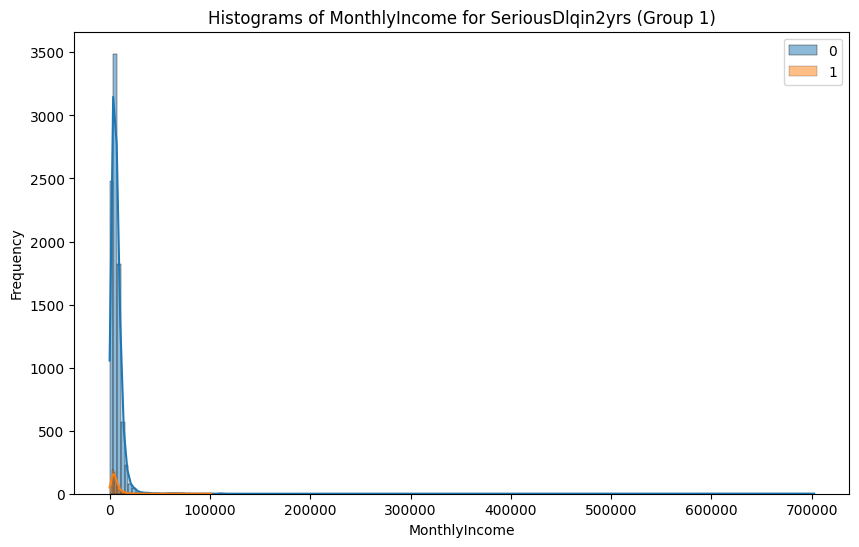

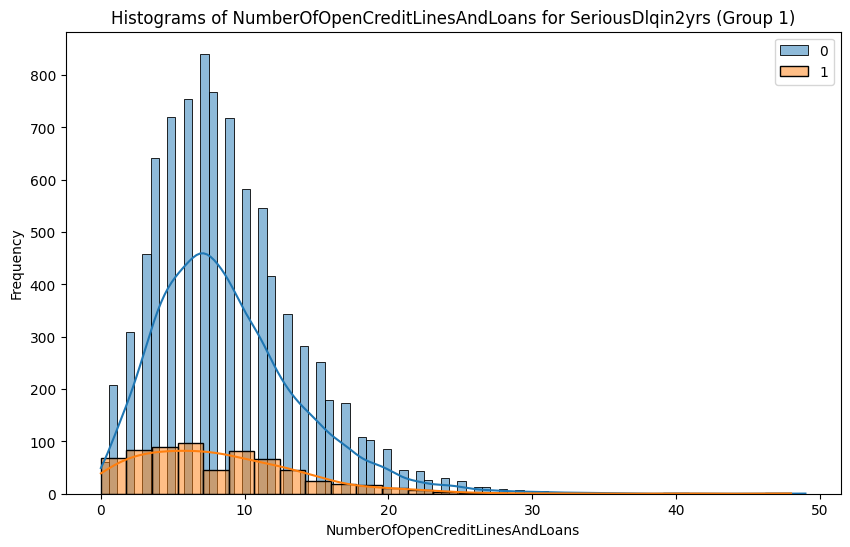

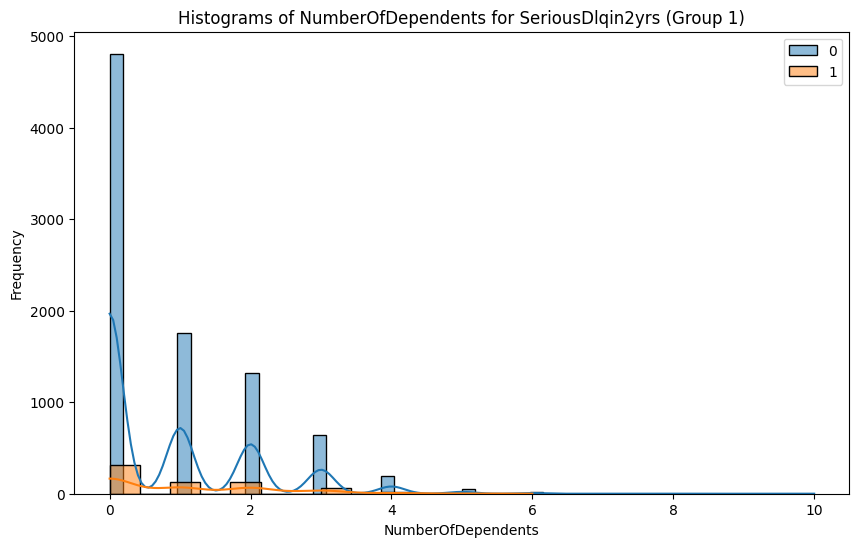

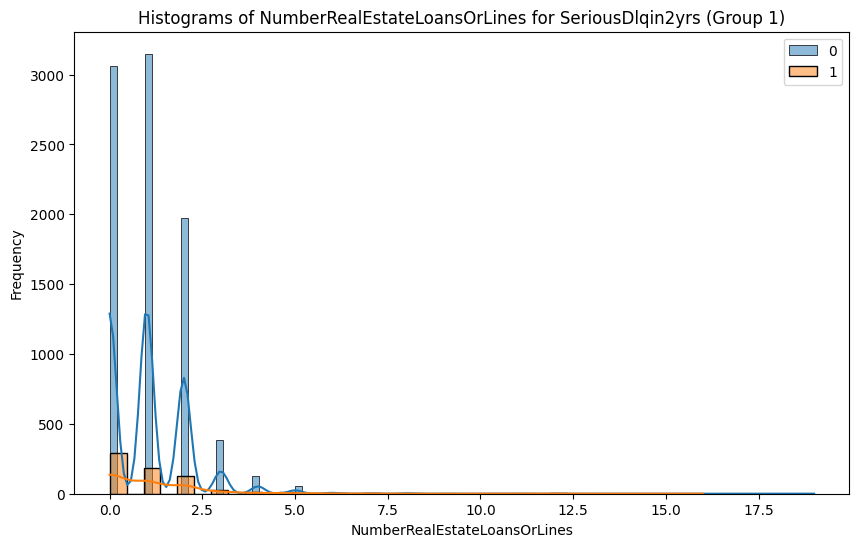

In [30]:
for col in features_num:
    bt.plot_grouped_histograms(train_set, cat_col= target, num_col= col, group_size= 2)

*Revolving, hay una diferencia marcada en valores bajos, así que me la quedo*


In [31]:
features_visual.append("RevolvingUtilizationOfUnsecuredLines")

*Del resto que me deje tranquilo el quedármela sólo veo "age" que tiene un posible punto (más de 70 años) a partir del cual la relación de pagadores a no pagadores se dispara (vamos que apenas hay inpagadores) (y ahí una relación parecida, pero en menor medida con los menores de 30-35):*

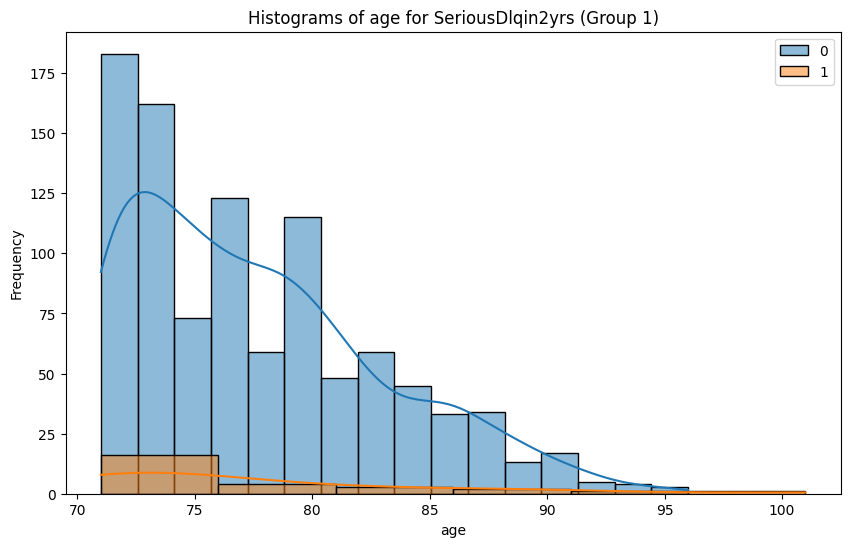

In [32]:
edad_cool = (train_set["age"] > 70)
bt.plot_grouped_histograms(train_set[edad_cool], cat_col = target, num_col= "age", group_size= 2)

*Me la quedo*

In [33]:
features_visual.append("age")

*Hay alguna que ya dejo en segunda división "NumberOfDependents", "NumberOfOpenCreditsAndLoans" y "RevolvingOperationsOfUnsecuredLines", en todas ellas o hay superposición o no se ven puntos de diferenciación claros*

*Tengo dudas, por el efecto de los outliers, en "MonthlyIncome" y "DebtRatio" así que los miro con "cariño":*

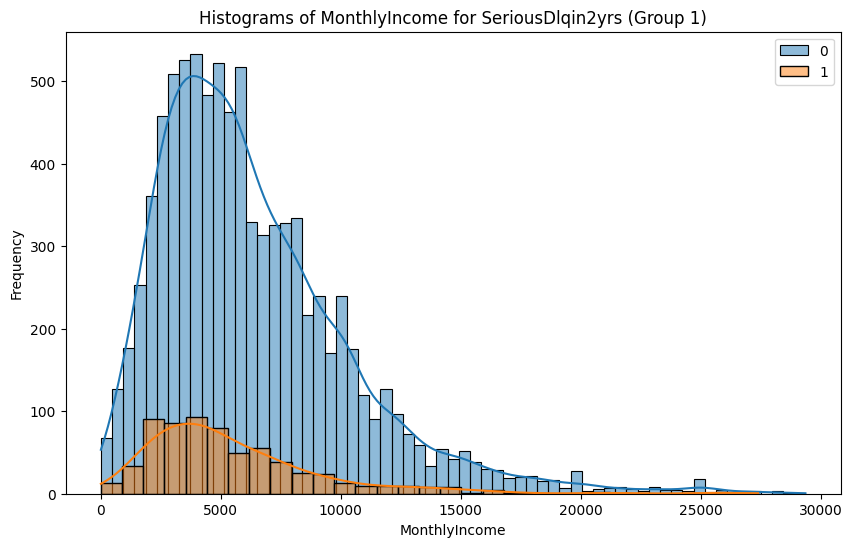

In [34]:
sin_monthlyincome_outliers = train_set["MonthlyIncome"] < 30000 # eL valor se escoge mirando el diagrama de caja, y no hay una regla fija, haz un diagrama de caja y obserfva que a partir de 20000 ya hay muchos outliers, escoger 30000 o 20000 es "indiferente" de primeras
bt.plot_grouped_histograms(train_set[sin_monthlyincome_outliers], cat_col= target, num_col= "MonthlyIncome", group_size= 2)

*Podría mandarla a segunda división, aunque existe un aumento importante de la relacción pagadores sobre no-pagadores a partir de más de 10000 de monthly income que invita a quedársela en "primera". Para asegurarme haré un test de U de Mann-Whitney*

In [35]:
cat_col = target
num_col = "MonthlyIncome"

grupo_a = train_set.loc[train_set[cat_col] == 0][num_col]
grupo_b = train_set.loc[train_set[cat_col] == 1][num_col]

u_stat, p_valor = mannwhitneyu(grupo_a, grupo_b)

print("Estadístico U:", u_stat)
print("Valor p:", p_valor)

Estadístico U: 3309844.0
Valor p: 4.937655211085432e-09


In [36]:
train_set["DebtRatio"].value_counts()

DebtRatio
0.000000    186
1.000000      3
0.376649      2
0.120576      2
0.001200      2
           ... 
0.480584      1
0.581226      1
0.221292      1
0.450358      1
0.647735      1
Name: count, Length: 9194, dtype: int64

*Me la quedo*

In [37]:
features_visual.append("MonthlyIncome")

*Vamos con DebtRatio*

In [38]:
train_set["DebtRatio"].describe()

count    9452.000000
mean        0.486047
std         2.505031
min         0.000000
25%         0.146204
50%         0.297564
75%         0.477876
max        96.000000
Name: DebtRatio, dtype: float64

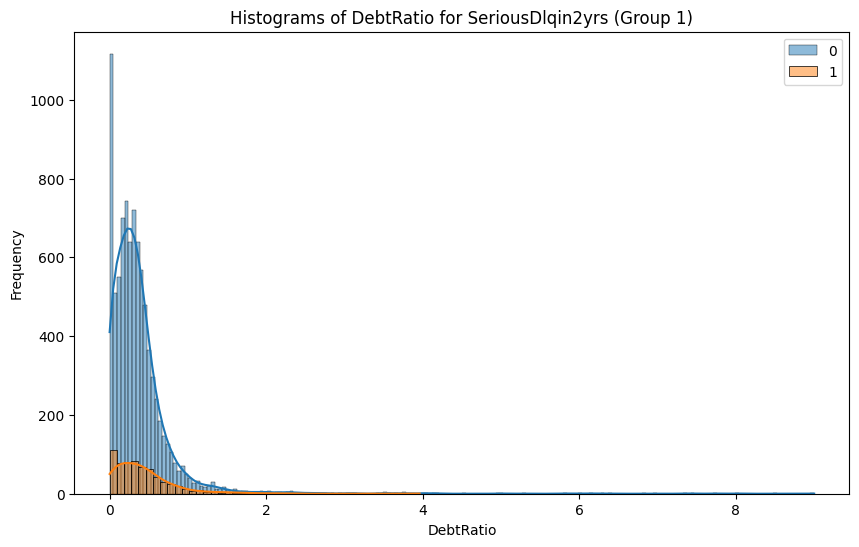

In [39]:
sin_debtratio_outliers = train_set["DebtRatio"] < 10 # eL valor se escoge mirando el diagrama de caja, y no hay una regla fija, haz un diagrama de caja y obserfva que a partir de 20000 ya hay muchos outliers, escoger 30000 o 20000 es "indiferente" de primeras
bt.plot_grouped_histograms(train_set[sin_debtratio_outliers], cat_col= target, num_col= "DebtRatio", group_size= 2)

*Tengo mis dudas, aunque el pico en 0 de pagadores me invita a quedarmela, haré también un test:*

In [40]:
cat_col = target
num_col = "DebtRatio"

grupo_a = train_set.loc[train_set[cat_col] == 0][num_col]
grupo_b = train_set.loc[train_set[cat_col] == 1][num_col]

u_stat, p_valor = mannwhitneyu(grupo_a, grupo_b)

print("Estadístico U:", u_stat)
print("Valor p:", p_valor)

Estadístico U: 2623985.5
Valor p: 1.920288228898668e-05


*Me la quedo (p-value <<<< 0.05)*

In [41]:
features_visual.append("DebtRatio")

In [42]:
features_visual

['N30-59',
 'N60-89',
 'N90',
 'RevolvingUtilizationOfUnsecuredLines',
 'age',
 'MonthlyIncome',
 'DebtRatio']

*Sobre lo que tengo hago un análisis de umbral de Varianza*

In [43]:
for umbral_varianza in np.arange(0,1,0.1):
    print(f"Para umbral = {umbral_varianza}")
    var_selector = VarianceThreshold(umbral_varianza)
    var_selector.fit(train_set[features_visual])
    print("Lista seleccionada para selector de Varianza", var_selector.get_feature_names_out())

Para umbral = 0.0
Lista seleccionada para selector de Varianza ['N30-59' 'N60-89' 'N90' 'RevolvingUtilizationOfUnsecuredLines' 'age'
 'MonthlyIncome' 'DebtRatio']
Para umbral = 0.1
Lista seleccionada para selector de Varianza ['N30-59' 'RevolvingUtilizationOfUnsecuredLines' 'age' 'MonthlyIncome'
 'DebtRatio']
Para umbral = 0.2
Lista seleccionada para selector de Varianza ['N30-59' 'age' 'MonthlyIncome' 'DebtRatio']
Para umbral = 0.30000000000000004
Lista seleccionada para selector de Varianza ['age' 'MonthlyIncome' 'DebtRatio']
Para umbral = 0.4
Lista seleccionada para selector de Varianza ['age' 'MonthlyIncome' 'DebtRatio']
Para umbral = 0.5
Lista seleccionada para selector de Varianza ['age' 'MonthlyIncome' 'DebtRatio']
Para umbral = 0.6000000000000001
Lista seleccionada para selector de Varianza ['age' 'MonthlyIncome' 'DebtRatio']
Para umbral = 0.7000000000000001
Lista seleccionada para selector de Varianza ['age' 'MonthlyIncome' 'DebtRatio']
Para umbral = 0.8
Lista seleccionada par

*Vaya lo que ocurre es que las categóricas con pocas categorías y no equilibradas se las come este selector, por eso sólo aplicalo a las variables contínuas y nos confirma por varianza que no está mal quedárselas. Probablemente es uno de lo selectores que menos vas a usar.*

4.4 **Análisis ANOVA y Mutual Information**

*Anova sobre las numericas:*

In [44]:
features_num

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfDependents',
 'NumberRealEstateLoansOrLines']

In [45]:
#features_num.remove("quality")
X_train = train_set[features_num]
y_train = train_set[target]
selector = SelectKBest(f_classif, k=4)
x_data_kbest = selector.fit_transform(X_train, y_train)
X_train_kbest = pd.DataFrame(x_data_kbest, columns = selector.get_feature_names_out())
X_train_kbest

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfOpenCreditLinesAndLoans,NumberOfDependents
0,0.391240,68.0,13.0,0.0
1,0.906540,59.0,7.0,1.0
2,0.933223,52.0,3.0,3.0
3,0.857859,50.0,9.0,0.0
4,0.000000,61.0,5.0,1.0
...,...,...,...,...
9447,0.397822,53.0,14.0,0.0
9448,0.015171,76.0,4.0,0.0
9449,0.988201,62.0,4.0,0.0
9450,0.122072,41.0,9.0,1.0


In [46]:
features_filter = list(selector.get_feature_names_out())

In [47]:
features_filter

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfDependents']

*Mutual Information para las categóricas:*

In [48]:
features_cat

['N30-59', 'N60-89', 'N90']

In [49]:
for col in features_cat:
    print(f"MI({col};{target}):", mutual_info_score(train_set[col],train_set[target]))

MI(N30-59;SeriousDlqin2yrs): 0.024765507782367968
MI(N60-89;SeriousDlqin2yrs): 0.017771329855032478
MI(N90;SeriousDlqin2yrs): 0.03421467132247159


*Nos quedamos las tres, sabiendo que podemos esperar más de N90 que de N30 y de N60.*

In [50]:
features_filter += features_cat

*Como la escala varía de 0 a lo que sea, no existe un punto de corte intuitivo, es un coeficiente que sirve para ordenar y si se quiere se puede relativizar:*

In [51]:
mi = {}
for col in features_cat:
    mi[col]  = mutual_info_score(train_set[col],train_set[target])
    print(f"MI({col};{target}):", mi[col])
pd.Series(mi)/sum(mi.values())

MI(N30-59;SeriousDlqin2yrs): 0.024765507782367968
MI(N60-89;SeriousDlqin2yrs): 0.017771329855032478
MI(N90;SeriousDlqin2yrs): 0.03421467132247159


N30-59    0.322671
N60-89    0.231544
N90       0.445785
dtype: float64

*Y establecer un punto arbitrario de corte por ejeplo por debajo de 0,1 (variables que aportan menos del 10% del Mutual Information ), pero es totalmente regla del "dedo gordo". Siguiendo esta regla nos quedaríamos las tres*

In [52]:
features_filter

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfDependents',
 'N30-59',
 'N60-89',
 'N90']

4.5 **Selección por modelo**

*Vamos a hacerlo primero con sklearn y SelectFromModel empleando las features con las variables ya categorizadas (N30...). Ojo al hiperparámetro class_weight que empleamos ya al estar tan desbalanceado del dataset de entrada*

In [53]:
features = features_num + features_cat
rf_selector = RandomForestClassifier(random_state= 42, class_weight= "balanced") #
selector_modelo = SelectFromModel(estimator = rf_selector, threshold= "median") # Nos quedamos con la mitad
selector_modelo.fit(train_set[features], train_set[target]) # X_train e y_train en los argumentos
features_modelo = list(selector_modelo.get_feature_names_out())
features_modelo

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'DebtRatio',
 'MonthlyIncome',
 'N30-59']

*Hmmm, bastante diferente de nuestras selecciones anteriores, las categóricas que prometían más se han caído en esta selección salvo una*

*Veamos como sería manualmente:*

In [54]:
rf_check = RandomForestClassifier(random_state= 42, class_weight= "balanced")
rf_check.fit(train_set[features], train_set[target])
df_importance= pd.DataFrame(rf_check.feature_importances_, columns = ["importance"], index = features)
df_importance.sort_values("importance",ascending = False)

,importance
RevolvingUtilizationOfUnsecuredLines,0.276869
DebtRatio,0.131723
MonthlyIncome,0.118579
age,0.114854
N30-59,0.084913
N90,0.083703
NumberOfOpenCreditLinesAndLoans,0.082429
NumberRealEstateLoansOrLines,0.035758
NumberOfDependents,0.035637
N60-89,0.035536


*Cortando por la mediana*

In [55]:
df_importance[df_importance.importance > df_importance.importance.median()]

,importance
RevolvingUtilizationOfUnsecuredLines,0.276869
age,0.114854
DebtRatio,0.131723
MonthlyIncome,0.118579
N30-59,0.084913


4.6 **RFE**

In [56]:
rf_RFE = RandomForestClassifier(class_weight= "balanced", random_state= 42)
rfe = RFE(estimator = rf_RFE,
        n_features_to_select= 6, # Iterará hasta quedarse con 6
        step = 1)
# (n_features - numero_de_features_quiero)/step
rfe.fit(train_set[features], train_set[target])

RFE(estimator=RandomForestClassifier(class_weight='balanced', random_state=42),
    n_features_to_select=6)

*NOTA: Podríamos haber probado con todas las featues que ahora incluirían la versión numérica y la categorizada de NumberOf...*

In [57]:
features_RFE = list(rfe.get_feature_names_out())
features_RFE

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'N30-59']

*Igual que la selección por modelo*

4.7 **Selección Secuencial (SFS)**

In [58]:
len(train_set.columns)

14

In [59]:
52 + 48 +44 + 40 +36

220

In [60]:
from sklearn.feature_selection import SequentialFeatureSelector

rf_SFS = RandomForestClassifier(class_weight= "balanced", random_state = 42)

sfs_forward = SequentialFeatureSelector(rf_SFS,
                                        n_features_to_select = 5,
                                        cv = 4,
                                        scoring = "balanced_accuracy")
# cuántos modelos entreno:
# 1a feature: 13 * 4 = 52
# 2a feature: 12 * 4 = 48
# 3a feature: 11 * 4 = 44
# 4a feature: 10 * 4 = 40
# 5a feature: 9 * 4 = 36

sfs_forward.fit(train_set[features], train_set[target])

SequentialFeatureSelector(cv=4,
                          estimator=RandomForestClassifier(class_weight='balanced',
                                                           random_state=42),
                          n_features_to_select=5, scoring='balanced_accuracy')

In [61]:
features_SFS = list(sfs_forward.get_feature_names_out())
features_SFS

['NumberOfDependents',
 'NumberRealEstateLoansOrLines',
 'N30-59',
 'N60-89',
 'N90']

*Tenemos para todos los gustos*

4.8 **Hard Voting**


*El hard-voting no es más que contar las veces que aparece repetida cada feature en las selecciones anteriores y qeudarnos con las "más votadas". En este caso nos quedaremos con las 6 más votadas, por lo que nos dice el eneunciado de no superar 6 features. Usaremos `Counter` del módulo collections*

In [62]:
lista_total = features_visual + features_filter + features_modelo + features_RFE + features_SFS
votaciones = Counter(lista_total)
votaciones

Counter({'N30-59': 5,
         'RevolvingUtilizationOfUnsecuredLines': 4,
         'age': 4,
         'N60-89': 3,
         'N90': 3,
         'MonthlyIncome': 3,
         'DebtRatio': 3,
         'NumberOfOpenCreditLinesAndLoans': 2,
         'NumberOfDependents': 2,
         'NumberRealEstateLoansOrLines': 1})

In [63]:
escrutinio = pd.DataFrame(votaciones.values(), columns = ["Votos"], index = votaciones.keys()).sort_values("Votos", ascending = False)
escrutinio


,Votos
N30-59,5
RevolvingUtilizationOfUnsecuredLines,4
age,4
N60-89,3
N90,3
MonthlyIncome,3
DebtRatio,3
NumberOfOpenCreditLinesAndLoans,2
NumberOfDependents,2
NumberRealEstateLoansOrLines,1


In [64]:
features_hard_voting = escrutinio["Votos"].nlargest(6).index.to_list()
features_hard_voting

['N30-59',
 'RevolvingUtilizationOfUnsecuredLines',
 'age',
 'N60-89',
 'N90',
 'MonthlyIncome']

5. **Modelado**



*Por simplificar y para evitarnos el escalado vamos a probar con RandomForest, XGBoost y LightGBM*

In [65]:
nombres = [f"Seleccion {nombre}" for nombre in ["visual", "filter","modelo","rfe","sfs","voting"]]
model_names = ["Random Forest","XGBoost", "LightGBM"]
rf_clf = RandomForestClassifier(class_weight= "balanced", random_state= 42)
xg_clf = XGBClassifier(random_state  = 42, scale_pos_weight = len(train_set[train_set[target] == 0])/len(train_set[train_set[target] == 1]))
lgb_clf = LGBMClassifier(class_weight= "balanced", random_state= 42, verbose = -100)
models = [rf_clf, xg_clf, lgb_clf]
resultados = []
for indice, lista in enumerate([features_visual, features_filter, features_modelo, features_RFE, features_SFS, features_hard_voting]):
    X_train = train_set[lista]
    y_train = train_set[target]
    for model_name, modelo in zip(model_names, models):
        metrica = np.mean(cross_val_score(modelo, X_train, y_train, cv = 5, scoring  = "balanced_accuracy"))
        data = {
            "features_list": nombres[indice],
            "model": model_name,
            "avg. recall": metrica
        }
        print(data)
        resultados.append(data.copy())
df_resultados = pd.DataFrame(resultados)
df_resultados.sort_values("avg. recall", ascending = False)


{'features_list': 'Seleccion visual', 'model': 'Random Forest', 'avg. recall': np.float64(0.5728532407129139)}
{'features_list': 'Seleccion visual', 'model': 'XGBoost', 'avg. recall': np.float64(0.6424797084147288)}
{'features_list': 'Seleccion visual', 'model': 'LightGBM', 'avg. recall': np.float64(0.718585685857393)}
{'features_list': 'Seleccion filter', 'model': 'Random Forest', 'avg. recall': np.float64(0.571761839906631)}
{'features_list': 'Seleccion filter', 'model': 'XGBoost', 'avg. recall': np.float64(0.6507265458983644)}
{'features_list': 'Seleccion filter', 'model': 'LightGBM', 'avg. recall': np.float64(0.7336713375413791)}
{'features_list': 'Seleccion modelo', 'model': 'Random Forest', 'avg. recall': np.float64(0.5303751415975057)}
{'features_list': 'Seleccion modelo', 'model': 'XGBoost', 'avg. recall': np.float64(0.6276511912856422)}
{'features_list': 'Seleccion modelo', 'model': 'LightGBM', 'avg. recall': np.float64(0.695997601643672)}
{'features_list': 'Seleccion rfe', 'm

,features_list,model,avg. recall
14,Seleccion sfs,LightGBM,0.736700
5,Seleccion filter,LightGBM,0.733671
13,Seleccion sfs,XGBoost,0.726941
17,Seleccion voting,LightGBM,0.726203
2,Seleccion visual,LightGBM,0.718586
11,Seleccion rfe,LightGBM,0.708522
12,Seleccion sfs,Random Forest,0.705693
8,Seleccion modelo,LightGBM,0.695998
16,Seleccion voting,XGBoost,0.666077
4,Seleccion filter,XGBoost,0.650727


*Nos quedamos con LightGBM y la selección secuencial, pero como estatiende al overfitting, también vamos a probar con la selección por filtrado*

In [66]:
features_SFS

['NumberOfDependents',
 'NumberRealEstateLoansOrLines',
 'N30-59',
 'N60-89',
 'N90']

6. **Ajuste fino y evaluación**

*Sobre SFS*

In [67]:
### LightGBM

param_grid = {
    "n_estimators": [100,200],
    "learning_rate": [0.1,0.5,1],
    "max_depth": [5,10,15],
    "min_data_in_leaf": [1,10,20,100],
    "class_weight":["balanced",None]
}

lgb_clf = LGBMClassifier(verbose = -100)
lgb_grid = GridSearchCV(lgb_clf,
                       param_grid= param_grid,
                       cv = 5,
                       scoring= "balanced_accuracy")

lgb_grid.fit(train_set[features_SFS],y_train)

GridSearchCV(cv=5, estimator=LGBMClassifier(verbose=-100),
             param_grid={'class_weight': ['balanced', None],
                         'learning_rate': [0.1, 0.5, 1],
                         'max_depth': [5, 10, 15],
                         'min_data_in_leaf': [1, 10, 20, 100],
                         'n_estimators': [100, 200]},
             scoring='balanced_accuracy')

In [68]:
lgb_grid.best_params_

{'class_weight': 'balanced',
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_data_in_leaf': 100,
 'n_estimators': 200}

In [69]:
X_test = test_set[features_SFS]
y_test = test_set[target]

In [70]:
y_pred = lgb_grid.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.84      0.90      2197
           1       0.22      0.59      0.32       167

    accuracy                           0.82      2364
   macro avg       0.59      0.71      0.61      2364
weighted avg       0.91      0.82      0.86      2364



*Sobre filtrado*

In [71]:

param_grid = {
    "n_estimators": [100,200],
    "learning_rate": [0.1,0.5,1],
    "max_depth": [5,10,15],
    "min_data_in_leaf": [1,10,20,100],
    "class_weight":["balanced",None]
}

lgb_clf = LGBMClassifier(verbose = -100)
lgb_grid_2 = GridSearchCV(lgb_clf,
                       param_grid= param_grid,
                       cv = 5,
                       scoring= "balanced_accuracy")

lgb_grid_2.fit(train_set[features_filter],y_train)

GridSearchCV(cv=5, estimator=LGBMClassifier(verbose=-100),
             param_grid={'class_weight': ['balanced', None],
                         'learning_rate': [0.1, 0.5, 1],
                         'max_depth': [5, 10, 15],
                         'min_data_in_leaf': [1, 10, 20, 100],
                         'n_estimators': [100, 200]},
             scoring='balanced_accuracy')

In [72]:
lgb_grid_2.best_params_

{'class_weight': 'balanced',
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_data_in_leaf': 100,
 'n_estimators': 100}

In [73]:
X_test = test_set[features_filter]
y_test = test_set[target]

In [74]:
y_pred = lgb_grid_2.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.81      0.88      2197
           1       0.21      0.65      0.31       167

    accuracy                           0.80      2364
   macro avg       0.59      0.73      0.60      2364
weighted avg       0.91      0.80      0.84      2364



In [75]:
features_filter

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfDependents',
 'N30-59',
 'N60-89',
 'N90']

### EXTRA

Aplica la PCA como método de selección, escoge un número de componentes en función de la varianza explicada y crea un dataset con el que entrenar el mismo tipo de modelo ganador de la parte general. Entrenalo y evalúalo contra test, comenta el resultado.

In [76]:
pca = PCA()
X_train = train_set[features]
X_test = test_set[features]
y_train = train_set[target]
y_test = test_set[target]
pca.fit(X_train, y_train)



PCA()

In [77]:
pca.explained_variance_ratio_

array([9.99998450e-01, 1.33058686e-06, 1.61626449e-07, 3.95235672e-08,
       8.28988436e-09, 6.30948793e-09, 1.93908103e-09, 6.92691976e-10,
       3.27650892e-10, 2.19118295e-10])

------------------------------------------
Porcentaje de varianza explicada acumulada
------------------------------------------
[0.99999845 0.99999978 0.99999994 0.99999998 0.99999999 1.
 1.         1.         1.         1.        ]


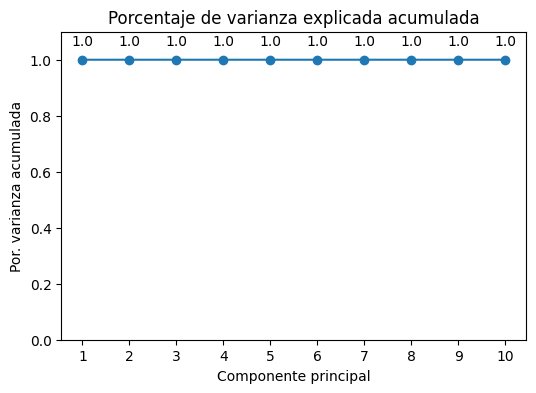

In [78]:
prop_varianza_acum = pca.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.plot(
    np.arange(len(X_train.columns)) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(len(X_train.columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');

*Con una componente....*

In [79]:
X_train_pca = pca.transform(X_train[features])
X_test_pca = pca.transform(X_test[features])
lgb_clf_pca = LGBMClassifier(**lgb_grid_2.best_params_, verbose = -100)

In [80]:
lgb_clf_pca.fit(X_train_pca[:,:1], y_train)
y_pred = lgb_clf_pca.predict(X_test_pca[:,:1])
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.55      0.70      2197
           1       0.08      0.49      0.13       167

    accuracy                           0.55      2364
   macro avg       0.51      0.52      0.41      2364
weighted avg       0.87      0.55      0.66      2364



c:\Users\Alberto Romero\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


*A pesar de que la primera comoponente ya lleva toda la varianza, eso no quiere decir que lleve todoel poder explicativo y no será hasta que emplemos 5-6 PCs que obtengamos unos resultados similares*

In [81]:
lgb_clf_pca.fit(X_train_pca[:,:7], y_train)
y_pred = lgb_clf_pca.predict(X_test_pca[:,:7])
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.83      0.89      2197
           1       0.24      0.71      0.36       167

    accuracy                           0.82      2364
   macro avg       0.61      0.77      0.63      2364
weighted avg       0.92      0.82      0.86      2364



c:\Users\Alberto Romero\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
